# Using Transition Matrix Methods under IndShockConsumerType

By William Du

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices with functions under the IndShockConsumerType.

The three key functions to non stochastically simulate are:

##### define_distribution_grid
- computes the grid of normalized market resources and the grid permanent income storing each as attributes of self.

###### calc_transition_matrix 
- computes transition matrix (matrices), a grid of consumption policies, and a grid asset policies stored as attributes of self. If the problem has a finite horizon, this function stores lists of transition matrices, consumption policies and asset policies grid for each period as attributes of self.

##### calc_ergodic_dist 
- computes the ergodic distribution stored as attributes. The distribution is stored as a vector (self.vec_erg_dstn) and as a grid (self.erg_dstn)



## Set up Computational Environment

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
import time
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt


C:\Users\wdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Set up the Dictionary

In [2]:

Dict={
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1.05**.25,                    # Interest factor on assets
    "DiscFac": 0.97,                       # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" :[1.00],                  # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
   
    "PermShkStd" :  [.05],                 # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.3],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" :  .2,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : .3,                       # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 90000,                  # Number of agents of this type
    "T_sim" : 600,                         # Number of periods to simulate
    "aNrmInitMean" : np.log(1.6)-(.5**2)/2,# Mean of log initial assets
    "aNrmInitStd"  : .5,                   # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
     }


## Create an Instance of IndShockConsumerType and Solve

In [3]:

example1 = IndShockConsumerType(**Dict)
example1.cycles = 0
example1.solve()


GPFRaw                 = 0.990911 
GPFNrm                 = 0.993135 
GPFAggLivPrb           = 0.984718 
Thorn = APF            = 0.990911 
PermGroFacAdj          = 0.997760 
uInvEpShkuInv          = 0.997760 
VAF                    = 0.961779 
WRPF                   = 0.218203 
DiscFacGPFNrmMax       = 0.983457 
DiscFacGPFAggLivPrbMax = 0.994090 


# Simulation: Transition Matrix vs Monte Carlo

This section compares monte carlo methods against the transition matrix approach in computing aggregate consumption and aggregate assets.

## Method 1: Monte Carlo 

In [4]:
#Simulate
example1.track_vars = ['aLvl']
example1.initialize_sim()
example1.simulate() #Simulate with Monte Carlo

#Compute Aggregate Consumption and Aggregate Assets
Monte_Carlo_Consumption = np.mean((example1.state_now['mNrm'] - example1.state_now['aNrm'])*example1.state_now['pLvl'])
Monte_Carlo_Assets = np.mean(example1.state_now['aNrm']*example1.state_now['pLvl'])

## Method 2: Transition Matrices

In [5]:

example1.define_distribution_grid()
p = example1.dist_pGrid # Grid of permanent income levels

example1.calc_transition_matrix()
c = example1.cPol_Grid #Normalized Consumption Policy Grid
asset = example1.aPol_Grid # Normalized Asset Policy Grid

example1.calc_ergodic_dist()
vecDstn = example1.vec_erg_dstn # Distribution of market resources and permanent income as a vector (m*p)x1 vector where 
# m is the number of market resource gridpoints and p is the number of permanent income gridpoints


In [6]:
#Compute Aggregate Consumption and Aggregate Assets
gridc = np.zeros((len(c),len(p)))
grida = np.zeros((len(asset),len(p)))

for j in range(len(p)):
    gridc[:,j] = p[j]*c # unnormalized Consumption policy grid
    grida[:,j] = p[j]*asset # unnormalized Asset policy grid
    
AggC = np.dot(gridc.flatten(),vecDstn) #Aggregate Consumption
AggA = np.dot(grida.flatten() ,vecDstn) #Aggregate Assets

### Comparing Steady State Outputs of Both Methods

In [7]:
print('TranMatrix Assets = ' + str(AggA[0]))
print('Simulated Assets = ' +str(Monte_Carlo_Assets))

print('TranMatrix Consumption = ' + str(AggC[0]))
print('Simulated Consumption = ' +str(Monte_Carlo_Consumption))

TranMatrix Assets = 1.1474302931355933
Simulated Assets = 1.2001867331617726
TranMatrix Consumption = 1.0051038032589252
Simulated Consumption = 1.0168991365573243


### Comparing Simulated Path of Aggregate Assets

The following code plots the path of aggregate assets simulatef from both Monte Carlo methods and transition matrix methods.

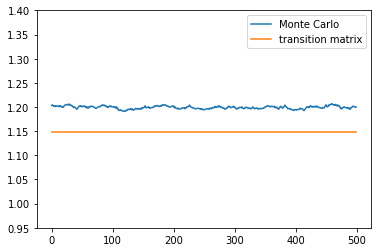

In [8]:
aLvls =[] # time series of aggregate assets

for i in range(example1.T_sim):
    aLvls.append(np.mean(example1.history['aLvl'][i])) #compute mean of aggregate assets across all agents for each period of the simulation
aLvls = np.array(aLvls)

plt.plot(aLvls[100:], label = 'Monte Carlo') # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.plot(np.ones(example1.T_sim-100)*AggA , label = 'transition matrix') # Plot time series path of aggregate assets computed using transition matrix
plt.ylim(.95,1.4)
plt.legend()
plt.show()
    

#### Precision vs Accuracy

Notice the mean level of aggregate assets differ between both simulation methods. The transition matrix plots a perfectly horizontal line as the initial distribution of agents across market resources and permanent is the unit eigenvector of the steady state transition matrix. Thus, as we take the produce of the transition matrix and the initial distribution, the new distribution does not change, implying the level of aggregate assets does not change. In contrast, the time series path simulated from Monte Carlo methods vacillates. This is because Monte Carlo methods are truly stochastic, randomly drawing shocks from a income distribution, while transition matrix methods are non-stochastic, the shock values are preset and the grid over market resources have is fixed. This contrast highlights the limitation of both methods, the monte carlo leads to a more accurate, yet less precise, level of aggregate assets while the transition matrix leads in precision but lacks  accuracy.  

### Comparing Distributions of Normalized Market Resources

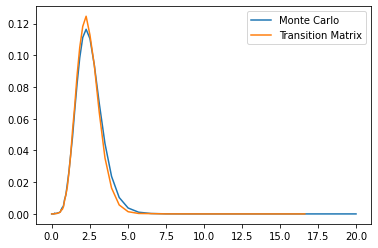

In [9]:
mdstn = np.zeros(48) 

for i in range(48):
    mdstn[i] = np.sum(example1.erg_dstn[i]) #distribution of normalized market resources

h = np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]/np.sum(np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins

plt.plot(example1.dist_mGrid,mdstn,label='Monte Carlo') #distribution using Monte Carlo
plt.plot(example1.dist_mGrid[:-1],h , label = 'Transition Matrix') # distribution using transition matrix method
plt.legend()
plt.show()


### Comparing Distributions of Permanent Income 

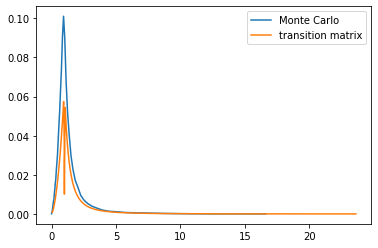

In [10]:

dstn = example1.erg_dstn

pdstn = np.zeros(len(dstn[0]))
for i in range(len(pdstn)):
    
    pdstn[i] = np.sum(dstn[:,i])
    
h = np.histogram(example1.state_now['pLvl'],bins=example1.dist_mGrid)[0]/np.sum(np.histogram(example1.state_now['pLvl'],bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins
plt.plot(example1.dist_mGrid[:-1],h,label='Monte Carlo') #distribution using Monte Carlo
plt.plot(example1.dist_pGrid,pdstn , label = 'transition matrix')
plt.legend()
plt.show()


# Calculating the Path of Consumption given an MIT shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. In particular, in this experiment, agents anticipates a change in the interest rate during period 10 and plots the simulated paths of aggregate consumption and aggregate assets.

### Compute Steady State Distribution

We will want the simulation to begin at the economy's steady state. Therefore first we will compute the steady state distribution over market resources and permanent income. This will be the distribution for which the computed transition matrices will be applied/multiplied to. 

In [11]:

ss = IndShockConsumerType(**Dict) 
ss.cycles = 0
ss.solve()

ss.define_distribution_grid()
p = ss.dist_pGrid # Grid of permanent income 

ss.calc_transition_matrix()
c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist()
vecDstn = ss.vec_erg_dstn # Steady State Distribution as a vector (m*p x 1) where m is the number of gridpoints on the market resources grid 
#and p is the number of gridpoints on the permanent income grid


GPFRaw                 = 0.990911 
GPFNrm                 = 0.993135 
GPFAggLivPrb           = 0.984718 
Thorn = APF            = 0.990911 
PermGroFacAdj          = 0.997760 
uInvEpShkuInv          = 0.997760 
VAF                    = 0.961779 
WRPF                   = 0.218203 
DiscFacGPFNrmMax       = 0.983457 
DiscFacGPFAggLivPrbMax = 0.994090 


## Simulating With Harmenberg (2021) Method

Harmenberg (2021) method may also be implemented when simulating with transition matrices. In cells 12 and 13, we compute the steady distribution using Harmenberg's method.

For more information on Harmenberg's Method to dramatically improve simulation times see https://econ-ark.org/materials/harmenberg-aggregation?launch


In [12]:
# Change the income process to use Neutral Measure
ss.neutral_measure = True 
ss.update_income_process()

In [13]:
# Set up grid and calculate transition Matrices
ss.define_distribution_grid()
ss.calc_transition_matrix()

c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist() #Calculate ergodic distribution
vecDstn_fast = ss.vec_erg_dstn #Distribution as a vector (mx1) where m is the number of gridpoint on the market resources grid


### Solve an Agent who Anticipates a Change in the Interest Rate

Now that we have the steady state distributions of which simulations will begin from, we will not solve an agent who anticipates a change in the interest rate. Solving the agent will provide the consumption policies to be used to calculate the transition matrices of this economy. 

In [14]:

# We will solve a finite horizon problem that begins at the steady state computed above. 
# Therefore parameters must be specified as lists, each item's index indicating the period of the horizon.

params = deepcopy(Dict)
params['T_cycle']= 20
params['LivPrb']= params['T_cycle']*[ss.LivPrb[0]]
params['PermGroFac']=params['T_cycle']*[1]
params['PermShkStd'] = params['T_cycle']*[ss.PermShkStd[0]]
params['TranShkStd']= params['T_cycle']*[ss.TranShkStd[0]]
params['Rfree'] = params['T_cycle']*[ss.Rfree]

FinHorizonAgent = IndShockConsumerType(**params)
FinHorizonAgent.cycles = 1
FinHorizonAgent.del_from_time_inv('Rfree') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('Rfree')
FinHorizonAgent.IncShkDstn = params['T_cycle']*ss.IncShkDstn
FinHorizonAgent.cFunc_terminal_ = deepcopy(ss.solution[0].cFunc) # Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent.track_vars = ['cNrm','pLvl'] 


### Implement perturbation in interest rate

In [15]:
dx=.01 # Change in the Interest Rate
i = 10 # Period in which the change in the interest rate occurs
FinHorizonAgent.Rfree = (i)*[ss.Rfree] + [ss.Rfree + dx] + (params['T_cycle'] - i -1 )*[ss.Rfree] # Sequence of interest rates the agent faces


### Solve Agent

In [16]:
FinHorizonAgent.solve()

### Calculate Transition Matrices

After the agent solves his problem, the consumption policies are stored in the solution attribute of self. calc_transition_matrix() will automatically call these attributes to compute the transition matrices.

In [17]:

start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

FinHorizonAgent.calc_agg_path(init_dstn = vecDstn) #calc_agg_path calculates the paths of aggregate assets and consumption storing each as attributes self.

AggC = FinHorizonAgent.AggC


seconds past : 56.96851992607117


calc_agg_path computes the paths of aggregate consumption and aggregate assets storing each time series as attributes of self given the initial distribution as an argument. This method is called after non stochastic simulation. 

### Calculate Transition matrices with Neutral Measure (Harmenberg 2021)

In [18]:
# Change Income Process to allow permanent income shocks to be drawn from neutral measure
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process()

# Calculate Transition Matrices
start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

#Calculate Macro Aggregates given Transition Matrices
FinHorizonAgent.calc_agg_path(init_dstn = vecDstn_fast)

AggC_fast = FinHorizonAgent.AggC

seconds past : 0.742750883102417


Notice the dramatic speed improvement.

### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$


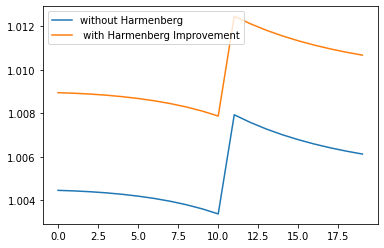

In [19]:

plt.plot(AggC, label = 'without Harmenberg') #Without Neutral Measure
plt.plot(AggC_fast, label = ' with Harmenberg Improvement') #With Harmenberg Improvement
plt.legend()
plt.show()


The minor difference in consumption paths is due to the fact that the original method's accuracy is limited by the size of the permanent income grid which in this exercise is only 101 points. Harmenberg's method eliminates the permanent income grid completely from the computation of aggregates and is more precise. 